# Advanced Lane Finding
This project uses advanced image processing techniques to identify street lanes. In this project the following steps are carried out to detect lane lines.
- Camera calibration
- Distortion correction
- Perspective transform
- Color and gradient thresholding
- Detect lane lines
- Determine the lane curvature

In [1]:
%matplotlib inline
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Loads calibration images
cal_files = glob.glob("./camera_cal/calibration*.jpg")

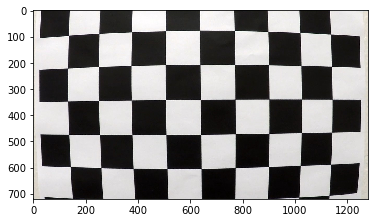

In [3]:
cal_img1 = mpimg.imread(cal_files[0])
plt.imshow(cal_img1)

### Camera Calibration
Camera calibration is done at the beginning and only once.

In [4]:
def detect_corners(images, nx, ny):
    # arrays to store all object points and image points from all images
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane

    # prepare object points like (0,0,0), (1,0,0),(2,0,0) ... (9,5,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates
    
    for img_name in images:
        img = mpimg.imread(img_name)
        
        # convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # find chessboardcorners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
            
    return objpoints, imgpoints

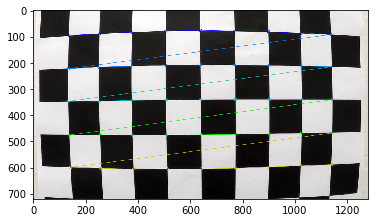

In [5]:
# calibrate the camera
img_test = mpimg.imread('./test_images/test5.jpg')
img_shape = (img_test.shape[1], img_test.shape[0])

objpts, imgpts = detect_corners(images = cal_files, nx = 9, ny = 5)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_shape, None, None)

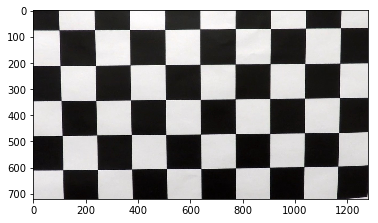

In [6]:
cal_img1_undist = cv2.undistort(cal_img1, mtx, dist, None, mtx)
plt.imshow(cal_img1_undist)

In [7]:
def plot_2_images(img1, img2, title1, title2, figsize=(10,8)):
    # show images
    fig = plt.figure(figsize=figsize)

    ax1 = fig.add_subplot(121)
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=20)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=20)

def plot_images(images, titles, figsize=(10,8), pos = 121):
    assert(len(images) == len(titles))
    
    fig = plt.figure(figsize=figsize)
    
    for i in range(len(images)):
        ax = fig.add_subplot(pos)
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i], fontsize=20)        
        pos += 1

### Image Distortion Correction

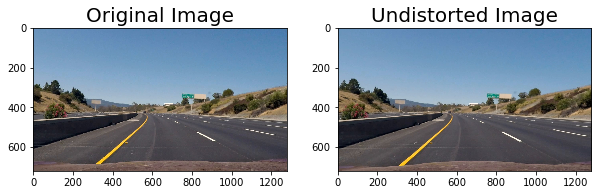

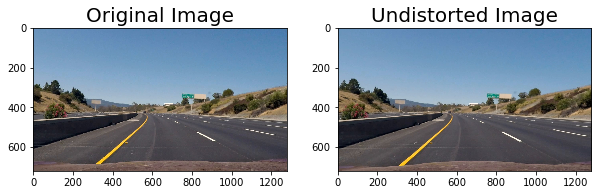

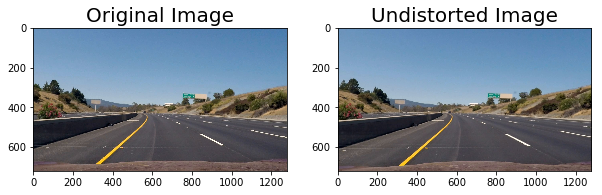

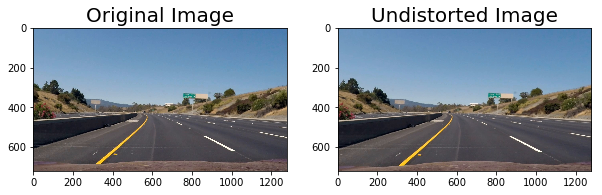

In [33]:
img_test6 = mpimg.imread('./test_images/test6.jpg')

# Loads calibration images
#test_images = glob.glob("./test_images/*.jpg")
#test_images = glob.glob("./challenge_video_images/*.jpg")
test_images = glob.glob("./project_video_images/*.jpg")
undist_images = []

for img_name in test_images[0:4]:
    img = mpimg.imread(img_name)
    # undistort image
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_images.append(img_undist)
    plot_2_images(img, img_undist, 'Original Image', 'Undistorted Image')
    

### Perspective Transform

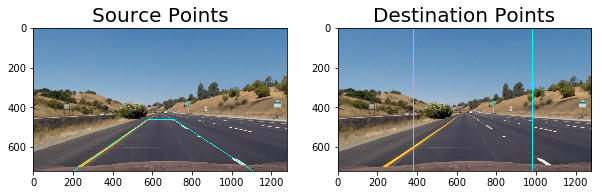

In [34]:
straight_img_path = ".\\test_images\\straight_lines1.jpg"
straight_img = mpimg.imread(straight_img_path)
straight_img_undist = cv2.undistort(straight_img, mtx, dist, None, mtx)

# Draw source points
pts = np.array([[710,460],[1110,720],[205,720],[575,460]], np.int32)
pts = pts.reshape((-1,1,2))
source_img = straight_img_undist.copy()
cv2.polylines(source_img,[pts],True,(0,255,255), 2)

# Draw destination points
pts = np.array([[980,0],[980,720],[380,720],[380,0]], np.int32)
pts = pts.reshape((-1,1,2))
dest_img = straight_img_undist.copy()
cv2.polylines(dest_img,[pts],True,(0,255,255), 2)

plot_images([source_img, dest_img], ["Source Points", "Destination Points"])

In [35]:
def warp(undist):
    src = np.float32([[710,460],[1110,720],[205,720],[575,460]])
    dst = np.float32([[1000,0],[1000,720],[300,720],[300,0]])    
        
    M = cv2.getPerspectiveTransform(src, dst)
    
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist, M, img_size)
          
    return warped, M

def warp2(undist, M):
    img_size = (undist.shape[1], undist.shape[0])    
    warped = cv2.warpPerspective(undist, M, img_size)          
    return warped

def unwarp(birds_eye_view, shape):
    src = np.float32([[1000,0],[1000,720],[300,720],[300,0]]) 
    dst = np.float32([[710,460],[1110,720],[205,720],[575,460]])
        
    Minv = cv2.getPerspectiveTransform(src, dst)
    
    img_size = (shape[1], shape[0])
    unwarped = cv2.warpPerspective(birds_eye_view, Minv, img_size)
          
    return unwarped, Minv

def unwarp2(birds_eye_view, Minv, shape):    
    img_size = (shape[1], shape[0])
    warped = cv2.warpPerspective(birds_eye_view, Minv, img_size) 
    return unwarped

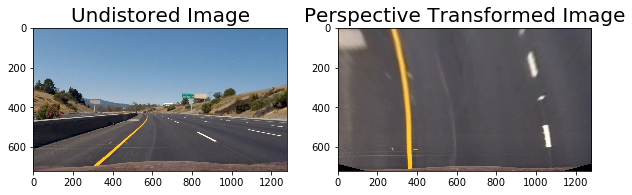

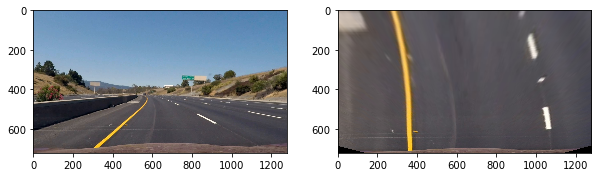

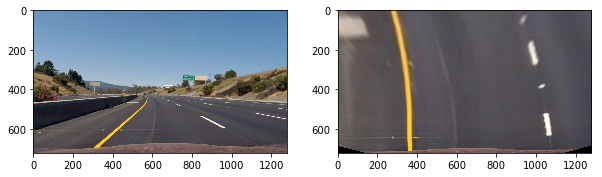

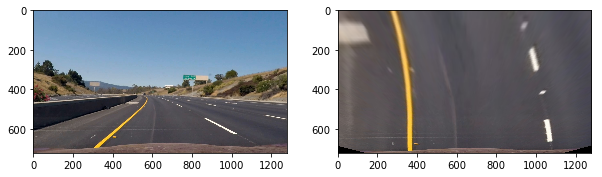

In [36]:
birds_eye_images = []

img_birds_eye, M = warp(undist_images[0])
birds_eye_images.append(img_birds_eye)
plot_2_images(undist_images[0], img_birds_eye, "Undistored Image", "Perspective Transformed Image")

for undist_img in undist_images[1:]:
    img_birds_eye = warp2(undist_img, M)    
    plot_2_images(undist_img, img_birds_eye, "", "")
    birds_eye_images.append(img_birds_eye)

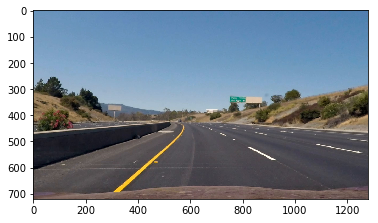

In [37]:
plt.imshow(undist_images[0])

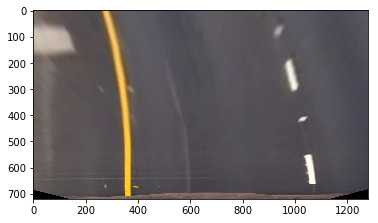

In [38]:
plt.imshow(img_birds_eye)

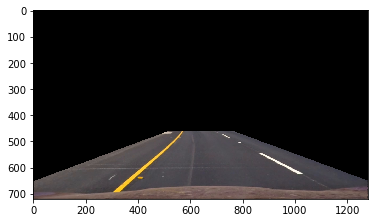

In [39]:
unwarped, Minv = unwarp(img_birds_eye, undist_images[0].shape)
plt.imshow(unwarped)

## Color Space Transformations
In the following cells I transform the test images into different color spaces like HSV, HSL, LUV and LAB.

In [40]:
def plot_channels(orig_img, birds_eye_img, img, channel_names, figsize=(18,9), fontsize=14):
    # show images
    fig = plt.figure(figsize=figsize)

    pos = 151
    
    ax1 = fig.add_subplot(pos)
    ax1.imshow(orig_img)
    ax1.set_title('Original', fontsize=fontsize)
    
    pos += 1
    
    ax2 = fig.add_subplot(pos)
    ax2.imshow(birds_eye_img)
    ax2.set_title('Birds Eye', fontsize=fontsize)
        
    for i in range(3):
        pos += 1
        ax = fig.add_subplot(pos)
        ax.imshow(img[:,:,i], cmap='gray')
        ax.set_title(channel_names[i], fontsize=fontsize)

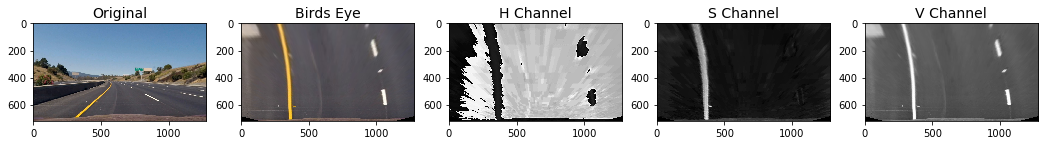

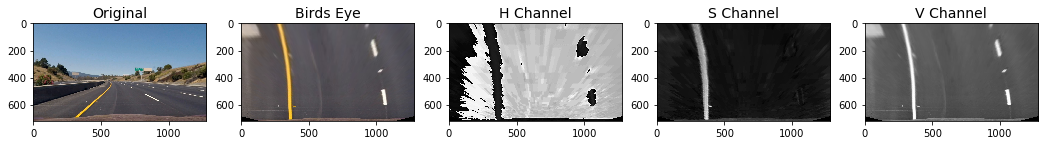

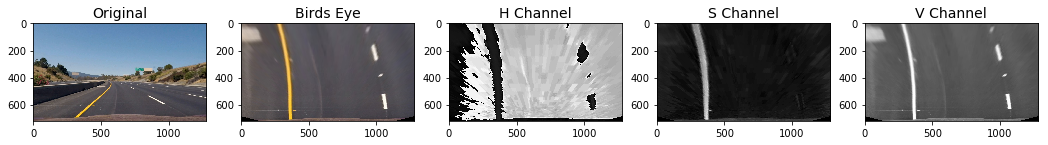

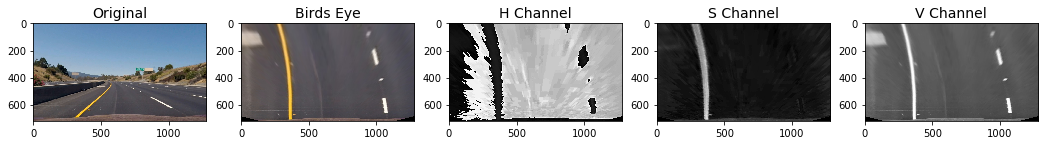

In [41]:
# convert images into HSV color space
for i in range(len(birds_eye_images)):
    undist_img = undist_images[i]
    birds_eye_img = birds_eye_images[i]
    hsv_img = cv2.cvtColor(birds_eye_img, cv2.COLOR_RGB2HSV)
    plot_channels(undist_img, birds_eye_img, hsv_img, ['H Channel', 'S Channel', 'V Channel'])

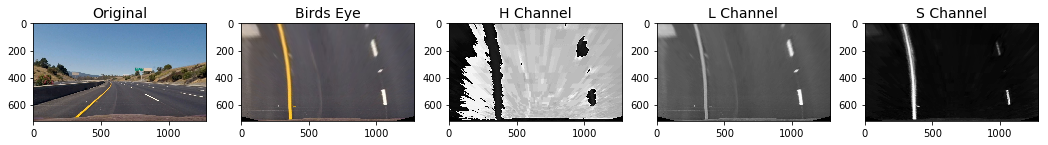

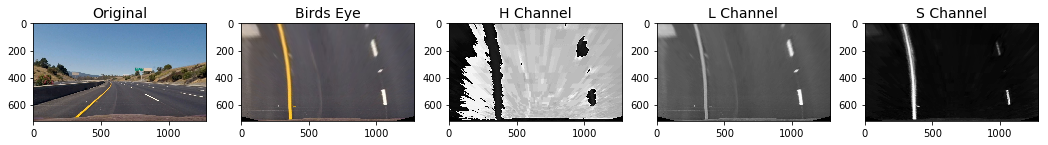

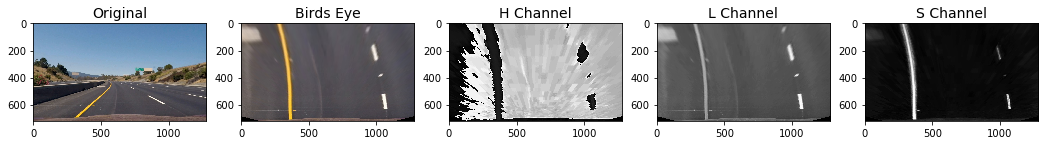

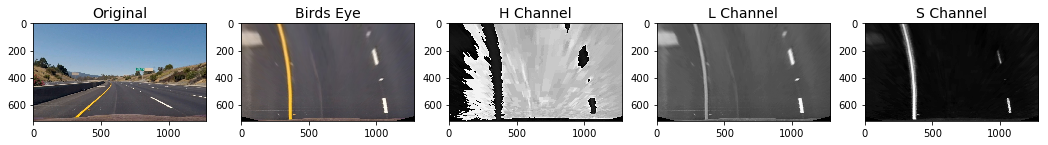

In [42]:
# convert images into HLS color space
for i in range(len(birds_eye_images)):
    undist_img = undist_images[i]
    birds_eye_img = birds_eye_images[i]
    hsv_img = cv2.cvtColor(birds_eye_img, cv2.COLOR_RGB2HLS)
    plot_channels(undist_img, birds_eye_img, hsv_img, ['H Channel', 'L Channel', 'S Channel'])

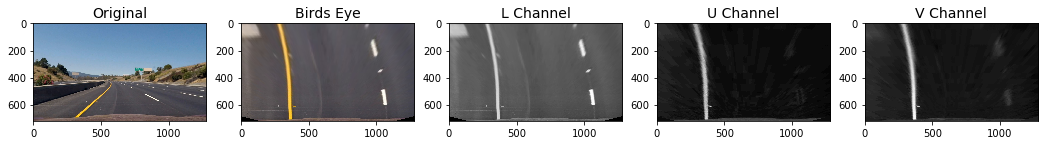

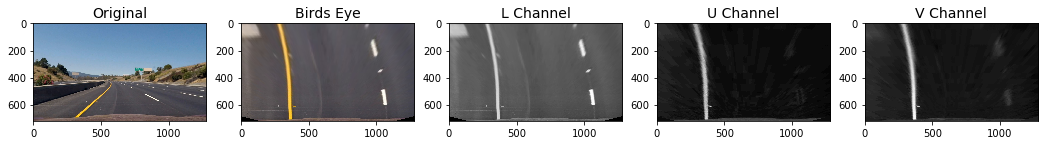

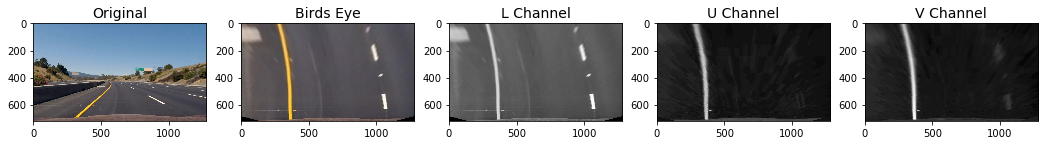

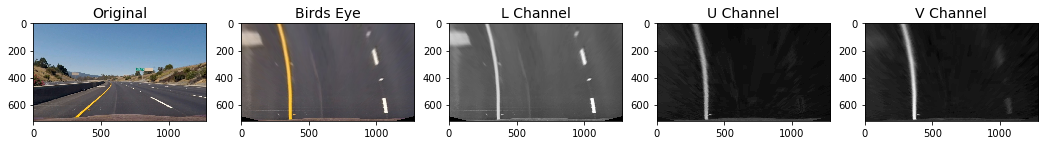

In [43]:
# convert images into LUV color space
for i in range(len(birds_eye_images)):
    undist_img = undist_images[i]
    birds_eye_img = birds_eye_images[i]
    luv_img = cv2.cvtColor(birds_eye_img, cv2.COLOR_RGB2LUV)
    plot_channels(undist_img, birds_eye_img, luv_img, ['L Channel', 'U Channel', 'V Channel'])

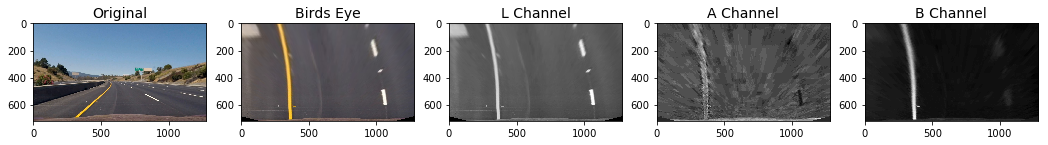

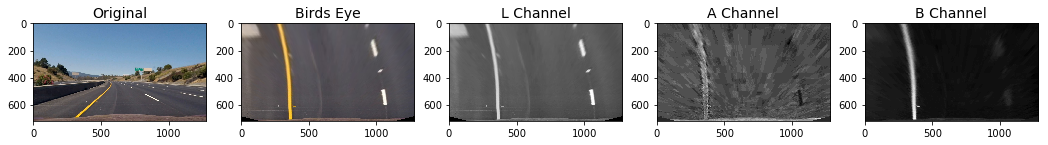

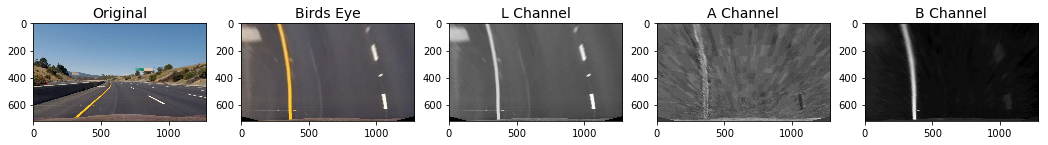

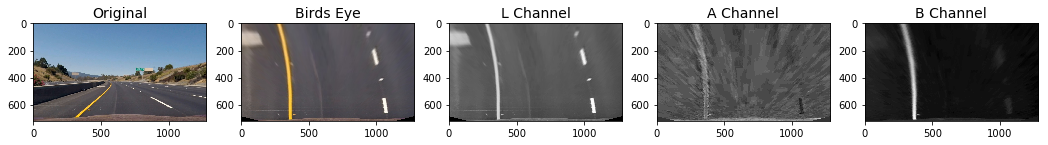

In [44]:
# convert images into LAB color space
for i in range(len(birds_eye_images)):
    undist_img = undist_images[i]
    birds_eye_img = birds_eye_images[i]
    luv_img = cv2.cvtColor(birds_eye_img, cv2.COLOR_RGB2LAB)
    plot_channels(undist_img, birds_eye_img, luv_img, ['L Channel', 'A Channel', 'B Channel'])

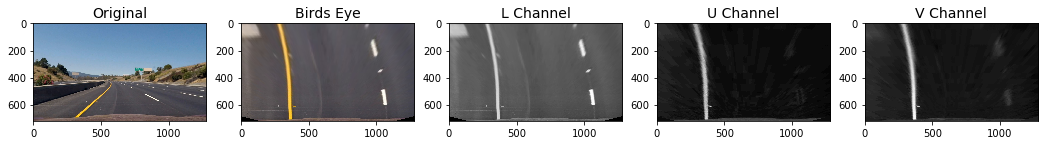

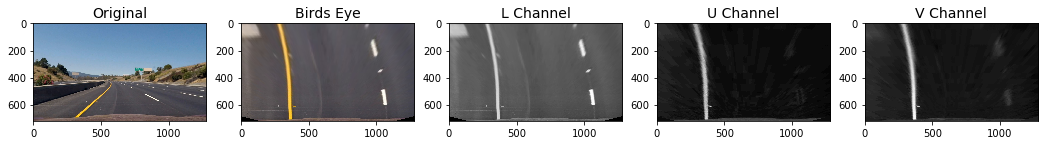

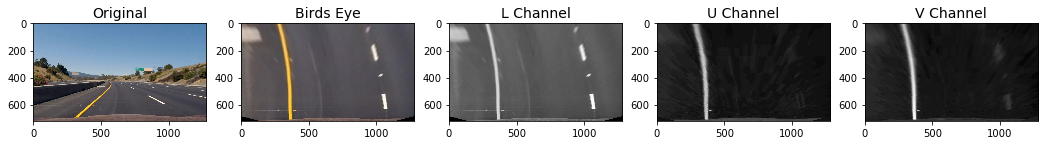

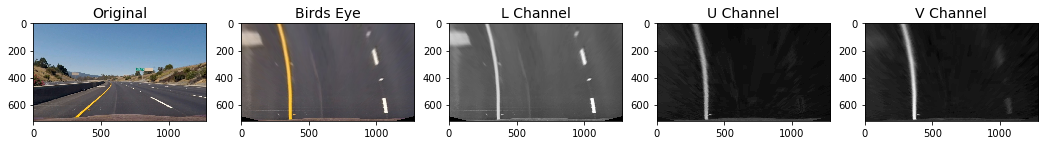

In [45]:
# convert images into LUV color space
for i in range(len(birds_eye_images)):
    undist_img = undist_images[i]
    birds_eye_img = birds_eye_images[i]
    luv_img = cv2.cvtColor(birds_eye_img, cv2.COLOR_RGB2LUV)
    plot_channels(undist_img, birds_eye_img, luv_img, ['L Channel', 'U Channel', 'V Channel'])

### Combined Binary Thresholding

In [46]:
def binary_thresholding(orig_img, birds_eye_img, channels, channel_names, thresholds, figsize=(18,9), fontsize=14, pos=151):
    assert(len(channels) == len(channel_names) == len(thresholds))
    
    fig = plt.figure(figsize=figsize)
    
    ax1 = fig.add_subplot(pos)
    ax1.imshow(orig_img)
    ax1.set_title('Original', fontsize=fontsize)
    
    pos += 1
    
    ax2 = fig.add_subplot(pos)
    ax2.imshow(birds_eye_img)
    ax2.set_title('Birds Eye View', fontsize=fontsize)
        
    binaries = []
    
    for i in range(len(channels)):
        thresh_min = thresholds[i][0]
        thresh_max = thresholds[i][1]
    
        binary = np.zeros_like(channels[i])
        binary[(channels[i] >= thresh_min) & (channels[i] <= thresh_max)] = 1        
        binaries.append(binary)
        
        pos += 1
        ax = fig.add_subplot(pos)
        ax.imshow(binary, cmap='gray')            
        ax.set_title(channel_names[i], fontsize=fontsize)
        
    # create a combined threshold
    combined_binary = np.zeros_like(binaries[0])
    
    for binary in binaries:
        combined_binary[(combined_binary == 1) | (binary == 1)] = 1    
    pos += 1
    ax = fig.add_subplot(pos)
    ax.imshow(combined_binary, cmap='gray')            
    ax.set_title('Combined', fontsize=fontsize)
    
    return combined_binary

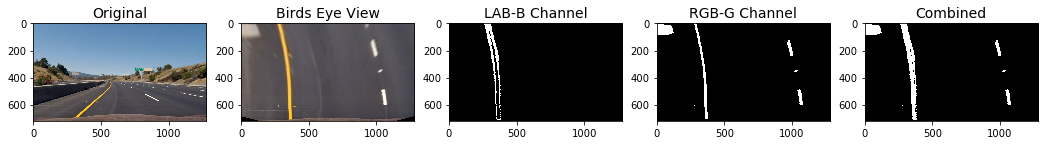

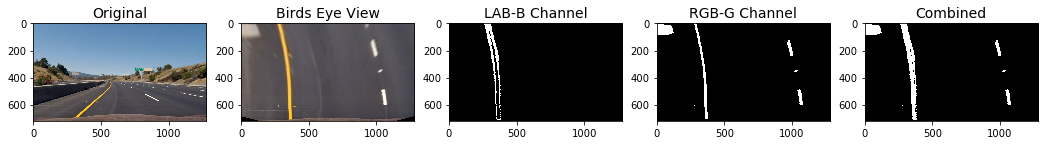

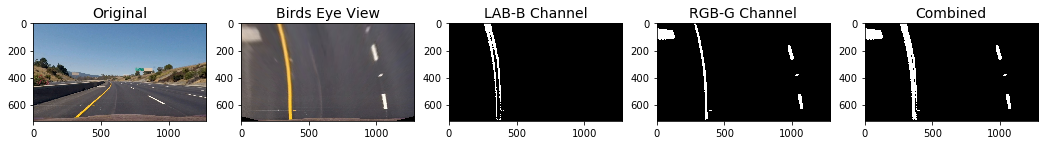

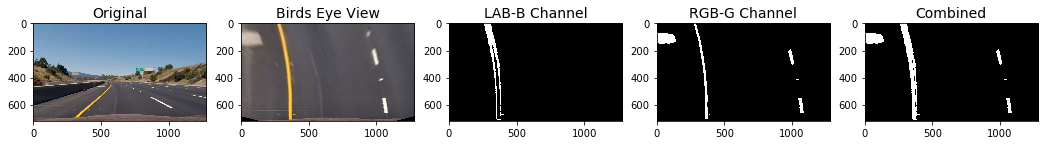

In [47]:
#ch_names = ['LAB-B Channel', 'HSV-V Channel', 'RGB-B Channel']
#threshes = [(145,180), (225,255), (200, 255)]

ch_names = ['LAB-B Channel', 'RGB-G Channel']
threshes = [(145,180), (170, 255)]

channel_combined_binaries = []

for i in range(len(birds_eye_images)):
    undist_img = undist_images[i]
    birds_eye_img = birds_eye_images[i]
    b_img = cv2.cvtColor(birds_eye_img, cv2.COLOR_RGB2LAB)[:,:,2]
    b_binary = np.zeros_like(b_img)
    b_binary[(b_img > 145) & (b_img <= 180)] = 1
    
    v_img = cv2.cvtColor(birds_eye_img, cv2.COLOR_RGB2HSV)[:,:,1]
    v_binary = np.zeros_like(v_img)
    v_binary[(v_img > 100) & (v_img <= 255)] = 1
    
    #luv_img = cv2.cvtColor(birds_eye_img, cv2.COLOR_RGB2LUV)[:,:,0]
    #luv_binary = np.zeros_like(luv_img)
    #luv_binary[(v_img > 170) & (v_img <= 255)] = 1
        
    #r_img = birds_eye_img[:,:,0]
    #r_binary = np.zeros_like(r_img)
    #r_binary[(v_img > 100) & (v_img <= 255)] = 1    
    
    # Green channel of RGB
    g_img = birds_eye_img[:,:,1]
    g_binary = np.zeros_like(g_img)
    g_binary[(g_img > 170) & (g_img <= 255)] = 1  
    
    #b_img = birds_eye_img[:,:,2]

    """
    pos = 151
    fig = plt.figure(figsize=(14,10))
    
    ax1 = fig.add_subplot(pos)
    ax1.imshow(b_binary, cmap='gray')
    ax1.set_title('B-Channel', fontsize=20)
    
    pos += 1
    
    ax2 = fig.add_subplot(pos)
    ax2.imshow(v_binary, cmap='gray')
    ax2.set_title('V-Channel', fontsize=20)
    
    pos += 1
    
    ax3 = fig.add_subplot(pos)
    ax3.imshow(r_binary, cmap='gray')
    ax3.set_title('R-Channel', fontsize=20)
    
    pos += 1
    
    ax4 = fig.add_subplot(pos)
    ax4.imshow(bb_binary, cmap='gray')
    ax4.set_title('RGB-B-Channel', fontsize=20)
    """
    
    ch_combined_binary = binary_thresholding(undist_img, birds_eye_img, [b_img, g_img], ch_names, threshes, pos=151)
    channel_combined_binaries.append(ch_combined_binary)


### Conclusion
I've tried different color spaces. Finally after several trials I decided to go with a combination of LAB and RGB color spaces. I use the B channel of the LAB color space and combine it with G channel of the RGB color space. Both channels are converted into binary images.
I use the following thresholds:
- B-Channel: min: 145, max: 180
- G-Channel: min: 170, max: 255


## Gradient thresholding
Gradient thresholding means that we calculate derivative of an image in x and y direction. For this purpose we use the Sobel operator which is also used by the Canny edge detection algorithm.

In [48]:
def directed_sobel(img, direction='x', kernel=3, min_thresh=0, max_thresh=255):
    # calculates derivative in x direction: 
    # 1, 0 at the end of the function denotes x direction
    # 0, 1 denotes y direction
    
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel) if direction == 'x' else cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel) 
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    
    # creates a binary images based on the provided min and max thresholds
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sbinary

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2]
    # Calculate the x and y gradients
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2]
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [49]:
thresh_min = 80
thresh_max = 120
kernel_size = 11

gradx = directed_sobel(img_birds_eye, 'x', kernel_size, thresh_min, thresh_max)
grady = directed_sobel(img_birds_eye, 'y', kernel_size, thresh_min, thresh_max)
mag_binary = mag_threshold(img_birds_eye, kernel_size, (thresh_min, thresh_max))
dir_binary = dir_threshold(img_birds_eye, kernel_size, (0.1, 0.4 ))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

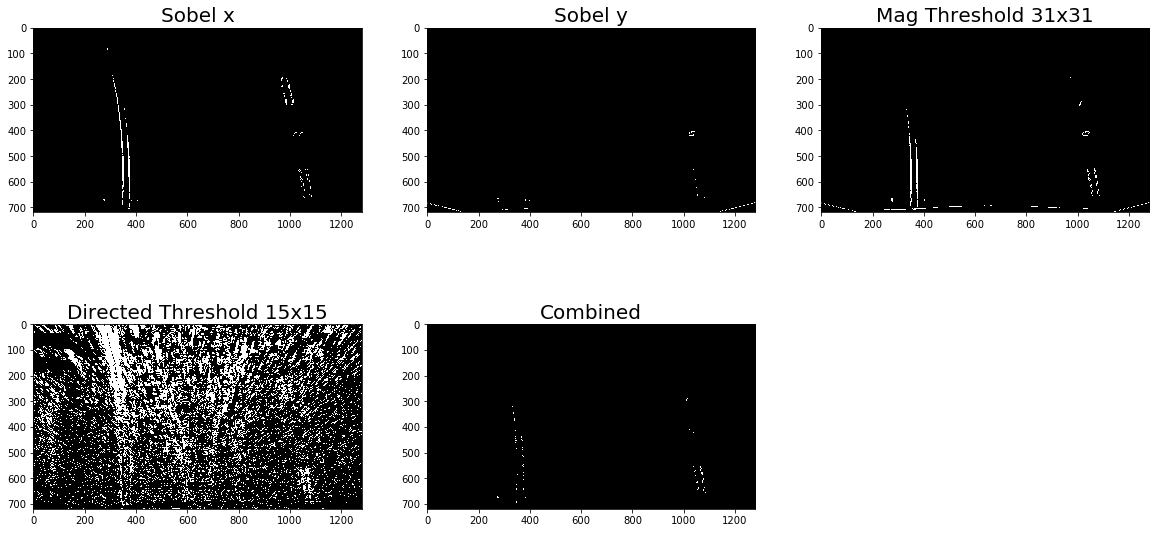

In [50]:
# show images
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(231)
ax1.imshow(gradx, cmap='gray')
ax1.set_title('Sobel x', fontsize=20)

ax2 = fig.add_subplot(232)
ax2.imshow(grady, cmap='gray')
ax2.set_title('Sobel y', fontsize=20)

ax3 = fig.add_subplot(233)
ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('Mag Threshold 31x31', fontsize=20)

ax4 = fig.add_subplot(234)
ax4.imshow(dir_binary, cmap='gray')
ax4.set_title('Directed Threshold 15x15', fontsize=20)

ax5 = fig.add_subplot(235)
ax5.imshow(combined, cmap='gray')
ax5.set_title('Combined', fontsize=20)

## Combined Color and Gradient Thresholds

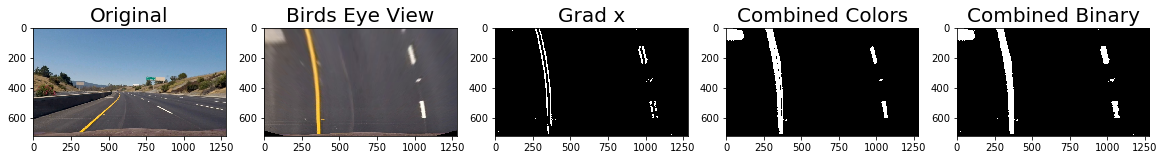

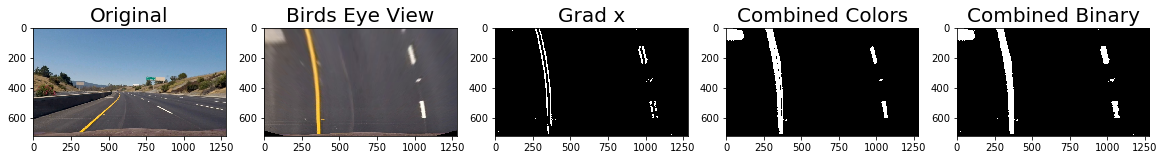

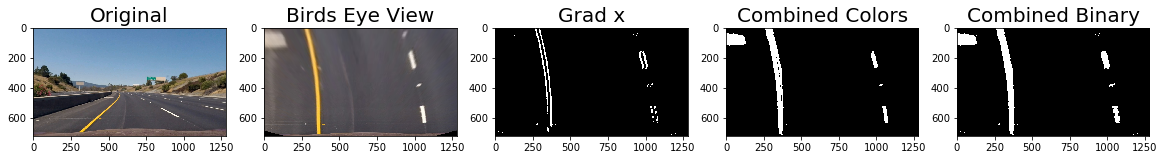

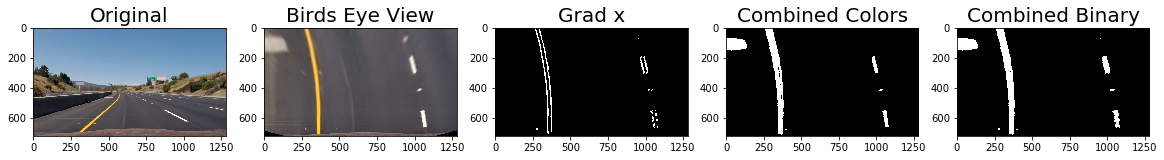

In [53]:
thresh_min = 50
thresh_max = 150
kernel_size = 11

titles = ["Original", "Birds Eye View", "Grad x", "Combined Colors", "Combined Binary"]

cg_binaries = []

for i in range(len(channel_combined_binaries)):
    undist_img = undist_images[i]
    birds_eye_img = birds_eye_images[i]
    gradx = directed_sobel(birds_eye_img, 'x', kernel_size, thresh_min, thresh_max)
    
    cg_binary = np.zeros_like(gradx)
    cg_binary[(gradx == 1) | (channel_combined_binaries[i] == 1)] = 1
    cg_binaries.append(cg_binary)
    
    plot_images([undist_img, birds_eye_img, gradx, channel_combined_binaries[i], cg_binary], titles, pos=151, figsize=(20,10))
    

## Finding Lanes

In [54]:
def calc_curvature(leftx, rightx, ploty):
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (round(left_curverad,1), round(right_curverad,1))

In [55]:
def project_lines(undist, warped, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

In [56]:
"""
def calc_vehicle_pos(leftx_base, rightx_base, midpoint):
    # lane midpoint
    lane_center = leftx_base + int((rightx_base - leftx_base) / 2)
    # calculate difference between lane midpoint and image midpoint which
    # is the deviation of the car to the lane midpoint
    diff = round(abs(lane_center - midpoint) * (3.7 / 700), 2)
    
    return diff
"""

def calc_vehicle_pos(leftx, rightx, midpoint):
    # lane midpoint
    lane_center = leftx + int((rightx - leftx) / 2)
    # calculate difference between lane midpoint and image midpoint which
    # is the deviation of the car to the lane midpoint
    diff = abs(lane_center - midpoint)
    print("lanecenter {}, midpoint {}, diff {}".format(lane_center, midpoint, diff))
    
    deviation = round(diff * (3.7 / 700), 2)
    
    return deviation

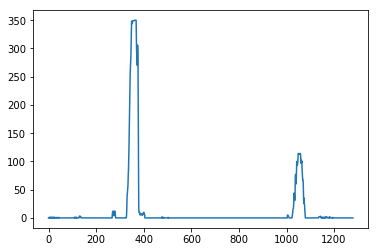

In [57]:
binary_image = cg_binaries[0]

histogram = np.sum(binary_image[binary_image.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [58]:
def sliding_window(binary_image):
    # crop the image. The last 20 pixel won't be taken into account because
    # these pixels belong to the engine hood and pixels which belong to it
    # shall not influence line finding
    binary_warped = binary_image.copy()[0:700,:]
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    pos = calc_vehicle_pos(leftx_base, rightx_base, midpoint)
    print(pos)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_image, binary_image, binary_image))*255
    
    # Choose the number of sliding windows
    nwindows = 10
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    # numpy.nonzero(): returns a tuple of arrays, one for each dimension, 2 arrays in this case.
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 30
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # numpy.polyfit: returns polynomial coefficients, highest power first.
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    # linspace: returns evenly spaced numbers over a specified interval.
    ploty = np.linspace(0, 720-1, 720 )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_points = np.dstack((left_fitx, ploty))[0]
    right_points = np.dstack((right_fitx, ploty))[0]
    color = (255,255,0)
        
    cv2.polylines(out_img, np.int32([left_points]), False, color, thickness=3, lineType=cv2.LINE_AA)
    cv2.polylines(out_img, np.int32([right_points]), False, color, thickness=3, lineType=cv2.LINE_AA)
    
    return left_fit, right_fit, out_img, left_fitx, right_fitx, ploty
    

lanecenter 699, midpoint 640, diff 59
0.31


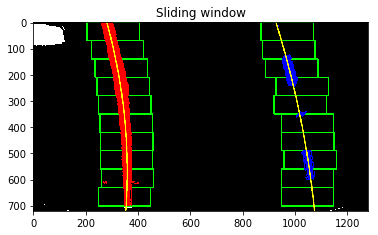

In [69]:
left_fit, right_fit, out_img, left_fitx, right_fitx, ploty = sliding_window(cg_binaries[0])
plt.imshow(out_img)
plt.title("Sliding window")

In [70]:
def search_next(binary_image, left_fit, right_fit):
    """
    Searches for the lines based on the result of the previous frame.
    """
    binary_warped = binary_image.copy()[0:700,:]
    
    # Get all nonzero pixels from the warped image.
    # Store the x and y indices in separate lists
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    ploty = np.linspace(0, 720-1, 720 )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Visualize the result
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_image, binary_image, binary_image))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    left_points = np.dstack((left_fitx, ploty))[0]
    right_points = np.dstack((right_fitx, ploty))[0]
    color = (255,255,0)
        
    cv2.polylines(result, np.int32([left_points]), False, color, thickness=3, lineType=cv2.LINE_AA)
    cv2.polylines(result, np.int32([right_points]), False, color, thickness=3, lineType=cv2.LINE_AA)
    
    plt.imshow(result)
    
    return left_fit, right_fit, result, left_fitx, right_fitx, ploty
    

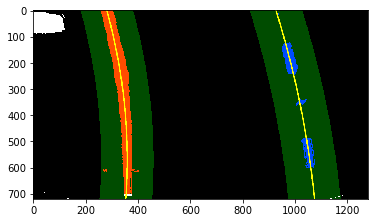

In [71]:
left_fit, right_fit, result, left_fitx, right_fitx, ploty = search_next(cg_binaries[1], left_fit, right_fit)

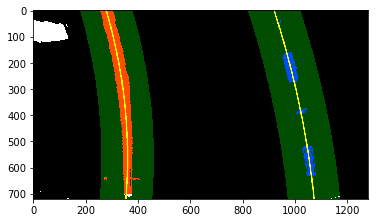

In [73]:
left_fit, right_fit, result, left_fitx, right_fitx, ploty = search_next(cg_binaries[2], left_fit, right_fit)

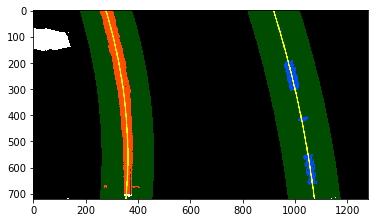

In [74]:
left_fit, right_fit, result, left_fitx, right_fitx, ploty = search_next(cg_binaries[3], left_fit, right_fit)

Now test this search approach on the project_video.mp4

In [34]:
left_fit = None
right_fit = None

def process_image(img):
    global left_fit
    global right_fit
    
    # undistort image
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # birds eye view
    img_birds_eye = warp2(img_undist, M)
        
    # binarize them
    b_img = cv2.cvtColor(img_birds_eye, cv2.COLOR_RGB2LAB)[:,:,2]
    b_binary = np.zeros_like(b_img)
    b_binary[(b_img >= 145) & (b_img <= 180)] = 1 
    
    v_img = cv2.cvtColor(img_birds_eye, cv2.COLOR_RGB2HSV)[:,:,2]
    v_binary = np.zeros_like(v_img)
    v_binary[(v_img >= 170) & (v_img <= 255)] = 1     
    
    # calc gradients in x direction using sobel operator
    gradx = directed_sobel(img_birds_eye, 'x', 11, 50, 100)
    
    # combine all binaries to a single binary image
    cg_binary = np.zeros_like(gradx)
    cg_binary[(b_binary == 1) | (v_binary == 1) | (gradx == 1)] = 1
    
    if left_fit is None:
        left_fit, right_fit, _, left_fitx, right_fitx, ploty = sliding_window(cg_binary)
    else:
        left_fit, right_fit, _, left_fitx, right_fitx, ploty = search_next(cg_binary, left_fit, right_fit)

    result_img = project_lines(img_undist, cg_binary, left_fitx, right_fitx, ploty)
    curvature = calc_curvature(left_fitx, right_fitx, ploty)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Left radius {} m, right radius {} m'.format(curvature[0], curvature[1])
    cv2.putText(result_img, text, (30,80), font, 1.2, (200,255,155), 4, cv2.LINE_AA)
    
    return result_img

lanecenter 718, midpoint 640, diff 78
0.41


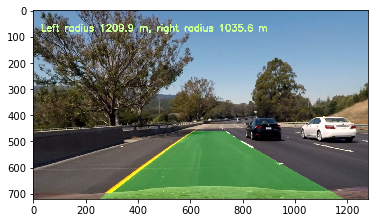

In [35]:
img_test6 = mpimg.imread('./test_images/test6.jpg')
img = process_image(img_test6)
plt.imshow(img)

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
img_cnt = 1
def store_images(image):
        global img_cnt
        if img_cnt > 20:
            return image
        
        img_name = '.\\challenge_video_images\\challenge_image{}.png'.format(img_cnt)
        plt.imsave(img_name, image)
        img_cnt += 1
        return image

In [38]:
output = 'challenge_video2.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video2.mp4
[MoviePy] Writing video challenge_video2.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:12<00:00,  7.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video2.mp4 

Wall time: 1min 13s
